In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
print("TF version: ", tf.__version__)
if tf.__version__ < "2.0.0":
    tf.enable_eager_execution()
    print("Eager execution enabled.")
else:
    print("Eager execution enabled by default.")

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

TF version:  2.4.1
Eager execution enabled by default.
Default GPU Device: /device:GPU:0


In [4]:
train_data = pd.read_csv('../input/sentiment-analysis-on-movie-reviews/train.tsv.zip', sep = '\t')
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [6]:
train_data.shape

(156060, 4)

In [7]:
test_data = pd.read_csv('../input/sentiment-analysis-on-movie-reviews/test.tsv.zip',sep = '\t')
test_data.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [8]:
print(test_data.shape)
test_data.info()

(66292, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [9]:
train_data.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [10]:
print(train_data['Sentiment'].unique())
train_data['Sentiment'].nunique()

[1 2 3 4 0]


5

In [11]:
train_data['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

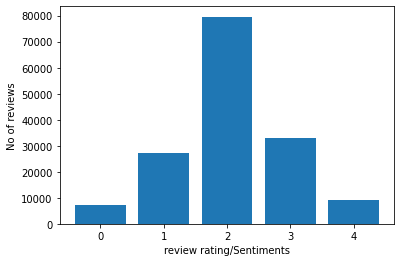

In [12]:
val_array = train_data['Sentiment'].value_counts().to_xarray()
plt.bar(val_array.index, val_array)
plt.xlabel('review rating/Sentiments')
plt.ylabel('No of reviews')
plt.show()

CPU times: user 34.4 s, sys: 1.15 s, total: 35.6 s
Wall time: 34.2 s


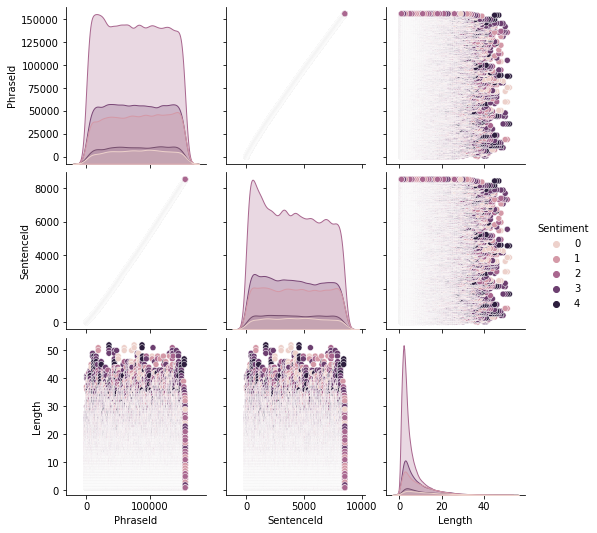

In [13]:
%%time
train_data['Length'] = train_data['Phrase'].apply(lambda x: len(str(x).split(' ')))
import seaborn as sns
sns.pairplot(train_data,hue='Sentiment',vars=['PhraseId','SentenceId','Length'])

In [14]:
from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re

In [15]:
def clean_sentences(df):
    
    reviews = []
    for sent in tqdm(df['Phrase']):
        # removing non-alphabetical characters 
        text = re.sub("[^a-zA-Z]"," ",sent)
        
        # Now tokenizing the sentence : 
        words = word_tokenize(text.lower())
        
        #removing stop words :
        new_words = [ ele for ele in words if ele.lower() not in stopwords.words('english') ]
        
        # Lemmatizing each word to its lemma
        lem = WordNetLemmatizer()
        lem_words = [lem.lemmatize(i) for i in new_words]
        
        #finally
        reviews.append(lem_words)
        
    return(reviews)


In [16]:
%%time
train_sentences = clean_sentences(train_data)
test_sentences = clean_sentences(test_data)

print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 66292/66292 [01:00<00:00, 1087.08it/s]

156060
66292
CPU times: user 3min 14s, sys: 21 s, total: 3min 35s
Wall time: 3min 34s


In [17]:
print(train_data['Phrase'][0])
print((" ").join(train_sentences[0]))

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
series escapade demonstrating adage good goose also good gander occasionally amuses none amount much story


In [18]:
from keras.utils import to_categorical

y_target = to_categorical(train_data['Sentiment'].values)


In [19]:
y_target.shape

(156060, 5)

The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

Set Training & Validation set to 80/20

In [20]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(train_sentences,y_target,test_size = 0.2,stratify = y_target)

In [21]:
X_train[0]

['john', 'heroic']

In [22]:
unique_words = set()
len_max = -1

for sent in tqdm(X_train):
    unique_words.update(sent)
    if(len_max < len(sent)):
        len_max = len(sent)

print('Words in vocab : ' , len(list(unique_words)))
print('Max_length : ' , len_max)

100%|██████████| 124848/124848 [00:00<00:00, 710551.91it/s]

Words in vocab :  13617
Max_length :  30


Now tokenizing the data set :

In [23]:
vocab_size = len(list(unique_words))
embedding_dim = 300
max_length = len_max
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [24]:
%%time
tokenizer = Tokenizer(num_words = vocab_size,
                      # filters = '#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      oov_token = oov_tok,
                      # lower = True,
                      char_level = False)

tokenizer.fit_on_texts(list(X_train))

# Training
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,
                        maxlen = max_length,
                        padding = padding_type,
                        truncating = trunc_type)

# Validation
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,
                      maxlen = max_length,
                      padding = padding_type,
                      truncating = trunc_type)

# Testing
X_test = tokenizer.texts_to_sequences(test_sentences)
X_test = pad_sequences(X_test,
                       maxlen = max_length,
                       padding = padding_type,
                       truncating = trunc_type)

CPU times: user 2.94 s, sys: 22.4 ms, total: 2.97 s
Wall time: 2.96 s


In [25]:
print("X_training shape   : ",X_train.shape)
print("X_validation shape : ",X_val.shape)
print("X_testing shape    : ",X_test.shape)

X_training shape   :  (124848, 30)
X_validation shape :  (31212, 30)
X_testing shape    :  (66292, 30)


In [26]:
print(X_train[2])

[996   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [27]:
from keras.models import Sequential
from keras.layers import Dense,Bidirectional,LSTM,Activation,Conv1D,MaxPool1D,Dropout
from keras.layers.embeddings import Embedding

In [28]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim,input_length = max_length))
model.add(Bidirectional(LSTM(128,dropout = 0.2, recurrent_dropout = 0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences=False)))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(y_target.shape[1],activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           4085100   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 256)           439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 4,705,905
Trainable params: 4,705,905
Non-trainable params: 0
_________________________________________________________________


In [29]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(min_delta = 0.001,
                               mode = 'max',
                               monitor = 'val_acc',
                               patience = 2)
callback = [early_stopping]

In [30]:
%%time

num_epochs = 4

history = model.fit(X_train,y_train,
                    validation_data = (X_val, y_val),
                    epochs = num_epochs,
                    batch_size = 256,
                    verbose = 1,
                    callbacks = callback)

Epoch 1/4
488/488 [==============================] - 265s 523ms/step - loss: 1.1333 - accuracy: 0.5458 - val_loss: 0.8696 - val_accuracy: 0.6467
Epoch 2/4
488/488 [==============================] - 252s 517ms/step - loss: 0.8036 - accuracy: 0.6727 - val_loss: 0.8364 - val_accuracy: 0.6600
Epoch 3/4
488/488 [==============================] - 251s 514ms/step - loss: 0.7222 - accuracy: 0.7017 - val_loss: 0.8320 - val_accuracy: 0.6616
Epoch 4/4
488/488 [==============================] - 252s 514ms/step - loss: 0.6722 - accuracy: 0.7190 - val_loss: 0.8347 - val_accuracy: 0.6668
CPU times: user 25min 17s, sys: 3min 16s, total: 28min 33s
Wall time: 16min 59s


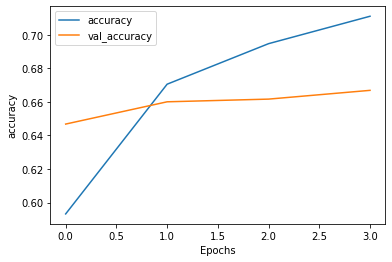

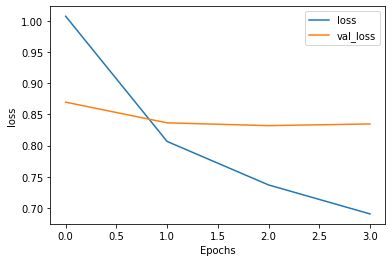

In [31]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [32]:
test_id = test_data['PhraseId']

In [33]:
%%time

y_pred = np.argmax(model.predict(X_test), axis = -1)

CPU times: user 53.2 s, sys: 526 ms, total: 53.7 s
Wall time: 52.4 s


In [34]:
submission_df = pd.DataFrame({'PhraseId': test_id, 'Sentiment': y_pred})
submission_df.to_csv('submission_.csv', index=False)
submission_df.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3
